In this notebook, we will be working through the makemore [video](https://www.youtube.com/watch?v=PaCmpygFfXo&t=3779s) by the GOAT Andrej Karpathy. Goal is to not simply copy paste code, but to type each character by hand and wrangle everything to build an intuitive understanding.

We will be learning how to create models which can generate names.

**What is makemore?** makemore is a character-level language model — it takes a dataset of words (in our case, human names) and learns to "make more" of them. Given enough training data, the model learns the statistical patterns of how characters follow each other and can generate new, plausible-sounding names that weren't in the original dataset.

This is the second video in Karpathy's "Neural Networks: Zero to Hero" series. Where the first video (micrograd) focused on building an autograd engine and understanding backpropagation, this video shifts focus to **language modelling** — the core task behind modern LLMs. We start with the simplest possible language model (bigrams) and will progressively build up to more powerful architectures in later videos (MLPs, RNNs, Transformers).


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
%matplotlib inline

# Section 1: Dataset Exploration

We will load our dataset and see what it looks like.

The dataset is a list of ~32K human names sourced from [ssa.gov](https://www.ssa.gov/oact/babynames/) (the US Social Security Administration's baby names database). Each line in the file is a single name in lowercase. This is the same dataset Karpathy uses across the entire makemore series, so it stays consistent as we move from bigrams to MLPs to RNNs.


In [2]:
DATASET_PATH = "./names.txt"

In [3]:
# utility to read dataset
def get_dataset():
    with open(DATASET_PATH, 'r') as f:
        rows = [row.strip() for row in f.readlines()]
    return rows

In [4]:
# load dataset
words = get_dataset()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [5]:
# Check a few properties of the dataset
print(f"Number of names = {len(words)}")
print(f"Shortest name: {min([(len(l), l) for l in words])}")
print(f"Longest name: {max([(len(l), l) for l in words])}")


Number of names = 32033
Shortest name: (2, 'aj')
Longest name: (15, 'muhammadmustafa')


For language modelling, there is another important point to be aware of. Take the word `isabella` for example. Is that a single example?

No, the word `isabella` tells us more than one thing.
It tells us that character `i` is likely to be the first letter in the sequence of a name.  
It tells us that character `s` is likely to follow the character `i` in the sequence of a name.  
It tells us that character `a` is likely to follow the characters `is` in the sequence of a name.  
It tells us that character `b` is likely to follow the characters `isa` in the sequence of a name.  
.  
.  
.  
It also tells us that after the characters `isabella` the word is likely to end.

Thus we actually can get more training examples from a single word for our dataset.

**Connecting to n-grams:** What we're doing here is decomposing each word into overlapping subsequences using a **sliding window**. For a bigram model, the window size is 2 (one character of context + one character to predict). For a trigram it would be 3, and so on. The general term for this family of models is **n-gram models**. The word `isabella` (with start/end tokens) gives us 10 bigrams: `.i`, `is`, `sa`, `ab`, `be`, `el`, `ll`, `la`, `a.` — each one is a separate training example. A dataset of 32K names, with an average name length of ~6 characters, yields roughly 200K+ bigram training examples.


# Section 2: Bigram

Bigram works by predicting what the next character will be given the current character. Its a very simple and weak language model and it only looks at what the previous character was to predict the next character. It ignores all the preceding characters apart from the previous character.

Formally, this is the **Markov assumption** (specifically a first-order Markov chain): the probability of the next character depends _only_ on the current character, not on any earlier history. In math: P(c*next | c_n, c*{n-1}, ..., c_1) ≈ P(c_next | c_n). This is obviously a massive simplification — the character that should follow `ma` in a name is very different from what should follow `za` — but it's a useful starting point because it's easy to estimate directly from counts.

Another important implementation detail while training any language model is that we always append a `start` and an `end` token, generally denoted as `<start>`, `<end>`. These two special tokens will let the model know that it needs to start generating characters (in our case) and stop generating characters respectively.

For simplicity for the bigram model here, we will be treating both these special tokens as a simple `.`.

**Why can we get away with a single token for both start and end?** Because in a bigram model, context is only one character long. The `.` at the start only ever appears as the _first_ character of a bigram (`.x`), telling us "what characters are likely to begin a name?" The `.` at the end only ever appears as the _second_ character (`x.`), telling us "after which characters is a name likely to end?" These two roles never conflict — `.` is never both the first and second element of the same bigram — so a single token works fine. In more complex models with longer context windows, you'd typically need separate tokens.


In [6]:
# for bigrams, we need to get all the paris of consecutive characters

for w in words:
    for c1, c2 in zip(w, w[1:]):
        print(c1, c2)
    break

e m
m m
m a


In [7]:
# we also need to add our special token
SPECIAL_TOKEN = "."

for w in words:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        print(c1, c2)
    break


. e
e m
m m
m a
a .


In [8]:
# we now need to capture the statistics of these consecutive characters, i.e. how often in our dataset does one character follow another
b = {}
for w in words:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        current_bigram = (c1, c2)
        b[current_bigram] = b.get(current_bigram, 0) + 1

b[('e', 'm')]

769

In [9]:
# lets get some stats on our bigrams, lets find out the most likely bigrams
sorted(b.items(), key = lambda kv: -kv[1])[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

We can see that `n` is very likely to be the ending character and that `a` is also very likely to come before `n`.

Looking at the top bigrams, a clear picture of English name patterns emerges:

- **Endings:** `n.` (6763) and `a.` (6640) dominate — names overwhelmingly tend to end in `n` or `a` (think: _evan_, _jordan_, _emma_, _sophia_).
- **Beginnings:** `.a` (4410) and `.k` (2963) are the most common starters.
- **Common interior patterns:** `an` (5438), `ar` (3264), `el` (3248), `ri` (3033) — these are the "glue" bigrams that appear in the middle of many names.

This is already a useful sanity check: the model's statistics match our intuition about what English names sound like.


In [10]:
# Instead of a dictinoary, lets store this information in a 2d array
# we will store this in a torch tensor. We will need to store counts for 26 characters and one special token i.e. we would need a 27 x 27 dim array

counts = torch.zeros((27, 27), dtype=torch.int32)
counts[0, :] # show the first row

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0], dtype=torch.int32)

In [14]:
# Now since tensor indexing needs integers, we will need to map each character and our special token to an integer
all_characters = [SPECIAL_TOKEN] + sorted(list(set(''.join(words))))
print(f"{''.join(all_characters)}")

.abcdefghijklmnopqrstuvwxyz


In [17]:
# creating mapping from character to integer and from integer to character
stoi = {s: i for i, s in enumerate(all_characters)}
itos = {i:s for s, i in stoi.items()}

print(f"{stoi=}")
print(f"{itos=}")

stoi={'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
itos={0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [ ]:
# Now we can populate our 2d count array/tensor

for w in words:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        counts[idx1, idx2] += 1

counts

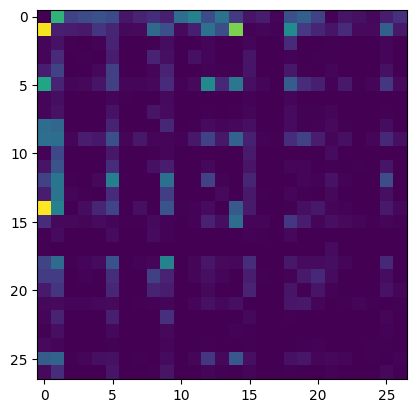

In [19]:
plt.imshow(counts)

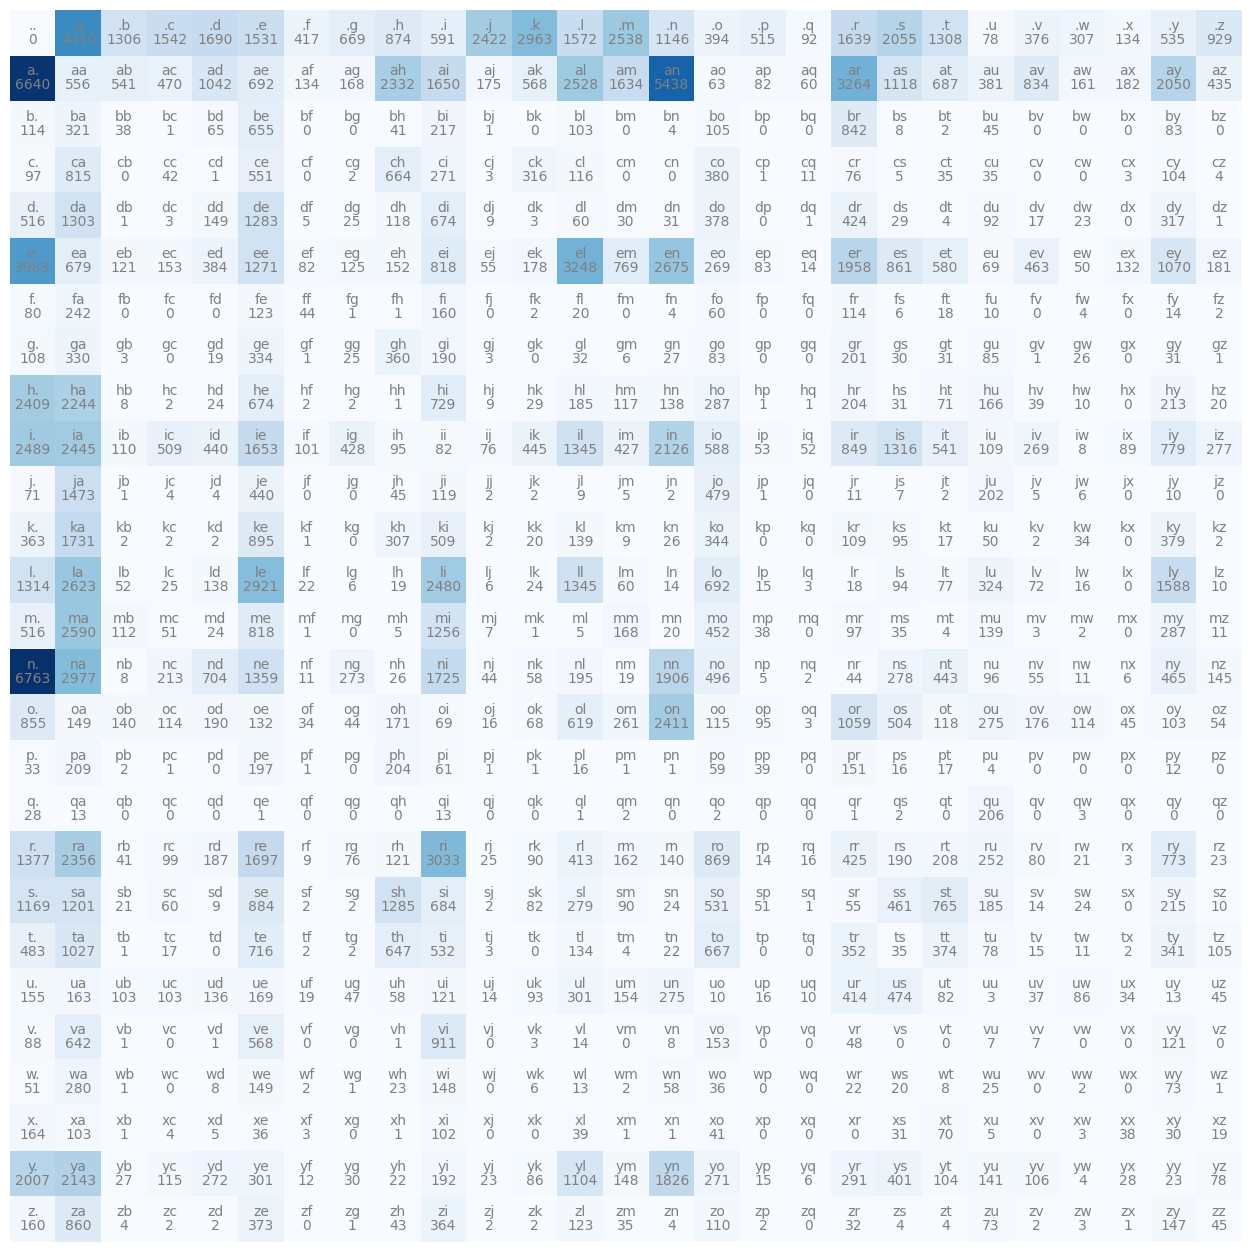

In [92]:
# lets try to create a better looking plot
import matplotlib.pyplot as plt
%matplotlib inline

def pretty_plot_matrix(counts):
    plt.figure(figsize=(16,16))
    plt.imshow(counts, cmap='Blues')
    for i in range(27):
        for j in range(27):
            chstr = itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
            plt.text(j, i, counts[i, j].item(), ha="center", va="top", color='gray')
    plt.axis('off');

pretty_plot_matrix(counts)

The way to read the above plot is: each cell shows, for a given pair of characters (row = first character, column = second character), how many times that bigram appears in the dataset. For example, `n.` appears 6,763 times, which matches what we saw in our bigram dictionary from before.

The colour intensity (darker blue = higher count) gives a quick visual sense of the distribution. You can immediately spot:

- The **bottom-left quadrant** (vowels followed by consonants and vice versa) tends to be darker — names alternate between vowels and consonants.
- The **first row** (`.` → something) shows which characters names tend to start with; the **first column** (something → `.`) shows which characters names tend to end with.
- Some cells are completely white (zero count) — certain bigrams like `qz` or `jx` simply never occur in English names.

This 27×27 grid is essentially the **entire model** — every piece of information the bigram model uses to generate names is captured in this one matrix.


In [ ]:
# we can compare with the top counts from our bigram dictionary to ensure that this plot looks correct
sorted(b.items(), key = lambda kv: -kv[1])[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

Another thing to note about this simple bigram model is that these `counts` are the parameters of our model.

This is worth pausing on: in a neural network, parameters are learned through gradient descent over many iterations of training. Here, the "training" was a single pass through the dataset counting co-occurrences — no gradients, no loss function, no backpropagation. The 27×27 = 729 entries in the count matrix fully define the model's behaviour.

To actually _use_ the model for generation, we'll need to convert these raw counts into **probabilities** (by normalizing each row so it sums to 1). Each row then becomes a probability distribution: "given that the current character is X, what is the probability of each possible next character?" This is the key step that turns a count table into a generative model.


# Section 2.1: Bigram Generation

Now that we have learned the "parameters" (counts in our case) of this simple model, lets look at how we can use it to generate words.

The core idea is **sampling from a probability distribution**. We can't just pick the most likely next character every time (that would always give us the same name). Instead, we want to sample _randomly_, but with characters that appeared more frequently in the training data being more likely to be chosen. This is exactly what `torch.multinomial` does — it draws samples from a distribution where each outcome's probability is proportional to its weight.


In [22]:
# The first row tells us how likely it is that the word starts with a particular character
counts[0, :]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [23]:
# These are raw counts, we need to convert these to probabilities to to be able to sample from it
p = counts[0, :].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [ ]:
# this now shows the probabilities of a word of starting with a particular character. We can use torch.multinomial to sample
# seed a generator first so that we can match the results from Karpathy's video.
g = torch.Generator().manual_seed(2147483647)

torch.multinomial(p, num_samples=20, replacement=True, generator=g) # lets get 20 samples from our probability distribution

tensor([13, 19, 14,  1,  1, 20, 20,  1, 13, 13, 13, 11, 23, 13, 19, 18, 26, 11,
         7, 19])

In [ ]:
# lets play with this sampler
sample_prob_distribution = torch.tensor([0.6, 0.3, 0.1]) # assume we only have 3 items to sample on.
# on sampling from this distribution, we would assume we get 60% of 0s, 30% of 1s and only 10% 2s.

torch.multinomial(sample_prob_distribution, num_samples=20, replacement=True, generator=g) # the more number of samples we get, the more it shuold match the probability distribution

tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2])

In [35]:
# lets now get a single sample from the first row's prob distribution, i.e. get a likely element which will start our word
g = torch.Generator().manual_seed(2147483647)
p_first_row = counts[0, :].float()
p_first_row = p_first_row / p_first_row.sum()

ix = torch.multinomial(p_first_row, num_samples=1, replacement=True, generator=g).item()
itos[ix]

'c'

Now once we have a character, what we can do is go to that character's row, in this case for `c` (row index 3), and sample from the probability distribution of that row. We keep doing this until we hit the end-of-word token `.`.

This is the **autoregressive generation loop**: start with the special token → sample the first character → use that character to look up the next row → sample again → repeat until we sample the `.` token. Each step only looks at the _current_ character (the Markov assumption in action).

Before proceeding with that though, lets first make another matrix which takes our count matrix, and converts each row into a probability distribution from which we can sample.

NOTE: We want each **row** to be a probability distribution and not each **column**. This is because rows represent "given this character, what comes next?" — row `i` holds the distribution P(next | current = i). If we normalized columns instead, we'd be answering a different question: "given that this character appeared next, what was the previous character?" — which is not what we need for generation.


In [39]:
# to convert each row to probabilities, we need the sum of each row. We then divide each element of the row by that sum.
row_sum = torch.sum(counts, axis=1)
row_sum.shape

torch.Size([27])

In [40]:
row_sum

tensor([32033, 33885,  2645,  3532,  5496, 20423,   905,  1927,  7616, 17701,
         2900,  5040, 13958,  6642, 18327,  7934,  1026,   272, 12700,  8106,
         5570,  3135,  2573,   929,   697,  9776,  2398])

## Broadcasting: Be Careful With Shapes!

We need to divide our `counts` matrix (shape `(27, 27)`) by the row sums so that each row becomes a probability distribution. But this is where **broadcasting** can silently do the wrong thing if we're not careful about tensor shapes.

### The problem

`counts.sum(axis=1)` gives us a 1D tensor of shape `(27,)` — just 27 numbers. When we try to divide a `(27, 27)` matrix by a `(27,)` vector, PyTorch's [broadcasting rules](https://pytorch.org/docs/stable/notes/broadcasting.html) kick in. Broadcasting aligns dimensions **from the right**, so:

```
counts:    (27, 27)
row_sum:       (27,)   ← aligns with the COLUMNS (axis 1), not the rows!
```

This means each **column** gets divided by a different value, not each **row**. That's the opposite of what we want — we'd end up normalizing columns instead of rows.

### The fix: `keepdim=True`

Using `counts.sum(axis=1, keepdim=True)` gives us a tensor of shape `(27, 1)` instead of `(27,)`. That extra dimension changes how broadcasting aligns:

```
counts:    (27, 27)
row_sum:   (27,  1)   ← aligns with the ROWS (axis 0) ✓
```

Now each row of `counts` is divided by its own row sum — exactly what we want. The `(27, 1)` tensor gets "stretched" (broadcast) across all 27 columns, so every element in row `i` is divided by the same value: the total count for row `i`.

### General rule of thumb

Whenever you reduce a dimension with `.sum()`, `.mean()`, etc. and plan to use the result in arithmetic with the original tensor, use `keepdim=True`. It preserves the reduced dimension as size 1, ensuring broadcasting aligns correctly. Alternatively, you can manually reshape with `.reshape(-1, 1)` or `.unsqueeze(1)`, but `keepdim=True` is cleaner.


In [42]:
count_probs = counts / counts.sum(axis=1, keepdim=True)
count_probs.shape

torch.Size([27, 27])

In [60]:
count_probs[0, :]

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

In [44]:
# Check that each row sums to 1
count_probs[10, :].sum()

tensor(1.)

In [53]:
# Now that we have out probability matrix, where each row is a prabability distribution over the next likely character, we can make our name generator!

def generate_names(count_probs, g):
    curr_idx = 0 # we start from the first row since that denotes the row with hte likely character following our start token '.'ArithmeticError
    name = []
    while True:
        next_charac_ix = torch.multinomial(count_probs[curr_idx], num_samples=1, replacement=True, generator=g).item()
        name.append(itos[next_charac_ix])
        if next_charac_ix == 0: # if the index sampled is the end token, we are done with the name generation
            break
        # set current idx to this new one
        curr_idx = next_charac_ix

    return ''.join(name)

In [58]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    name = generate_names(count_probs, g)
    print(name)

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
enkaviyny.
ftlspihinivenvorhlasu.
dsor.
br.
jol.
pen.
aisan.
ja.
feniee.
zem.
deru.
firit.
gaikajahahbevare.
kiysthelenaririenah.
keen.
x.
al.
kal.
thavazeeromysos.
laitenimieegariseriyen.
k.
illeleldole.
meenisammigama.
mmin.
asharin.
alcalar.
jayn.
asaz.
selanely.
chay.
rana.
ai.
yviamisashougen.
l.
beyncaro.
allan.
annutetoradrilia.
rddeman.


We have some names which dont look like names at all! While this may seem wrong, the reason it looks like this is because our model is extremely simple!

Remember: the bigram model only ever looks at _one_ character of context. It has no idea that `ftlspihinivenvorhlasu` is nonsensical — all it knows is that `f` can be followed by `t`, `t` can be followed by `l`, etc. Each individual bigram transition might be reasonable, but the model has no mechanism to enforce _global_ coherence across the whole name. That's why later models in this series (MLPs, RNNs, Transformers) use longer context windows — they can "remember" more of the name so far.

Lets sanity check this. We ran the name generation using our learned parameters which were the count matrix (subsequently the probability matrix). Lets try to see what a random model would do instead. So for that, if we use a uniform probability matrix, where every character is equally likely to be the next character, then it would simulate our random model and the results should look much much worse than what we got above.


In [50]:
uniform_probability_distribution = torch.zeros_like(count_probs)
uniform_probability_distribution[:] = 1.0 / 27.0 # every character is likely to be the next one
uniform_probability_distribution[0, :]

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

In [57]:
g = torch.Generator().manual_seed(2147483647)

for i in range(50):
    name = generate_names(uniform_probability_distribution, g)
    print(name)

cexzm.
zoglkurkicqzktyhwmvmzimjttainrlkfukzkktda.
sfcxvpubjtbhrmgotzx.
iczixqctvujkwptedogkkjemkmmsidguenkbvgynywftbspmhwcivgbvtahlvsu.
dsdxxblnwglhpyiw.
igwnjwrpfdwipkwzkm.
desu.
firmt.
gbiksjbquabsvoth.
kuysxqevhcmrbxmcwyhrrjenvxmvpfkmwmghfvjzxobomysox.
gbptjapxweegpfwhccfyzfvksiiqmvwbhmiwqmdgzqsamjhgamcxwmmk.
iswcxfmbalcslhy.
fpycvasvz.
bqzazeunschck.
wnkojuoxyvtvfiwksddugnkul.
fuwfcgjz.
abl.
j.
nuuutstofgqzubbo.
rdubpknhmd.
vhfacdvaaasjzjkdh.
gh.
frdhlhahflrklmlcugro.
pnxhayx.
vn.
gixgosfqn.
mempfnclfxtirbqhvjfdwhzymayerzqvmzjvtjuifbooocnkcxjkvsmjafciekxoraw.
.
veigtbcaamnef.
chfeukwowgsadjjkkswrcpawhoxskfikwbscynndmiuxxwoturzhqnsjdndsziocnbxiegzzulhnqdqwosi.
kdwnfjvmtthtpzbmdvvrvtptaqlhdnkj.
zxkcbczsrcagitwicvkcqiotgnvpllciqs.
uohjxnvxqikebadkdawdfwwha.
fqcnmrpoljlpjldyjehpprjppsmkzdhrmgyoadmsod.
dnvzcobtzfikidecxjhbmmjxqphvtedjbwkxzhisndnoauiycrdfetifkvzlzf.
ud.
ckndsgyldqbkcylrozgwkjgftrahdrnfapspdayna.
thavpgelvlfqxxsdabgxpyzv.
ikzvrykvyxhuj.
qkpwzuaics.
xxqubplmqguhbpnetz.
.
t

The results with the uniform distribution, i.e. a random model, look much worse. Thus we can convince ourselves that our learned bigram model is actually working, it is just not a good model :).

Notice a few things about the uniform model's output:

- **Names are much longer** — because the probability of generating `.` (the stop token) is only 1/27 ≈ 3.7%, whereas in our trained model, common endings like `n.` and `a.` have much higher probability, so names terminate sooner.
- **Consonant clusters are everywhere** — sequences like `qzktyhwmvmz` are common because every character is equally likely, so there's no learned preference for vowel-consonant alternation.
- **No recognisable structure** — the trained model at least produces fragments that _sound_ English (like `ka`, `pen`, `allan`), while the uniform model is pure noise.

This comparison is a great way to build intuition: even a model as simple as bigram counts captures meaningful structure from the data. The question now becomes: _how do we measure how good or bad a model is, quantitatively?_ That's where **loss functions** come in — up next.


# Section 2.2: Bigram Model Quality

Let us now try to figure out how good this model is. To do that, let us start with understanding how "probable" or "likely" is our input dataset given the model parameters. To reiterate, in our simple bigram model, the model parameters are just probabilities of transition to the next character, i.e. our `count_probs` matrix.

This is a fundamental question in machine learning: we've built a model, but **how do we measure its quality with a single number?** We need a **loss function** — a scalar value that tells us how well (or poorly) the model fits the data. The idea here is to use the model's own probability assignments as a quality metric: a good model should assign _high_ probability to sequences that actually appear in the training data.


In [ ]:
for w in words[:3]: # take a few sample words
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = count_probs[idx1, idx2]

        print(f"{c1}{c2}: Prob: {prob:.4f}")

.e: Prob: 0.0478
em: Prob: 0.0377
mm: Prob: 0.0253
ma: Prob: 0.3899
a.: Prob: 0.1960
.o: Prob: 0.0123
ol: Prob: 0.0780
li: Prob: 0.1777
iv: Prob: 0.0152
vi: Prob: 0.3541
ia: Prob: 0.1381
a.: Prob: 0.1960
.a: Prob: 0.1377
av: Prob: 0.0246
va: Prob: 0.2495
a.: Prob: 0.1960


If our model was random and every character was equally likely, then we would expect all of these probabilities to be 0.037 or roughly 4%. We can see that our model is assigning much better probabilities, i.e. we can see that `ma` is almost 39% likely to occur based on our model. On the flip side, for a perfect or oracle model, all these probabilities would have been 1 or 100%.

Lets think about how we can summarize this into a single number.

From statistical modelling and **Maximum Likelihood Estimation (MLE)** we know that the **likelihood** will be the product of all these probabilities. What that number will tell us is the probability of the entire dataset assigned by our model. That number should be as high as possible and will be 1 for an oracle/god/perfect model.

**Why multiply?** Each bigram transition is assumed to be independent (given the current character). For independent events, the joint probability is the product of individual probabilities: P(dataset) = P(bigram₁) × P(bigram₂) × ... × P(bigramₙ). This is the **likelihood function** — the probability of observing our data given the model's parameters. MLE says: the best parameters are the ones that _maximise_ this likelihood. For the bigram model, the count-based probabilities we computed are actually the exact MLE solution — counting and normalising is the optimal thing to do.


In [ ]:
likelihood = 1
for w in words[:3]:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = count_probs[idx1, idx2]
        likelihood *= prob
        # print(f"{c1}{c2}: Prob: {prob:.4f}"

print(f"Likehood for the first three words: {words[:3]} is {likelihood}")

Likehood for the first three words: ['emma', 'olivia', 'ava'] is 1.4309086396644506e-17


As we can see, since probabilities are always <= 1, multiplying a bunch of them together will yield smaller and smaller numbers, which are not only hard to understand but can also **underflow** (become so small that floating point can't represent them, collapsing to 0.0) and lead to numerical instability.

That is where **Log Likelihood** comes in. Taking the logarithm of the likelihood solves both problems at once.


/tmp/ipykernel_15139/454403938.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(xs, np.log(xs))


Text(0.5, 1.0, ' Probability vs Log Probability')

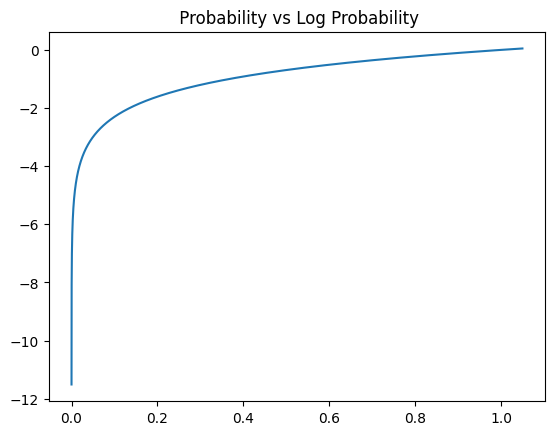

In [74]:
xs = np.arange(0, 1.05, 0.00001)
plt.plot(xs, np.log(xs))
plt.title(" Probability vs Log Probability")

From the log curve of a probability distribution, we can see that it is monotonically increasing, going to -∞ at prob=0 and reaching 0 at prob=1. This has two key benefits:

1. **Monotonicity preserves ordering.** Since log is a monotonically increasing function, maximising the likelihood is equivalent to maximising the log likelihood. If model A assigns higher likelihood than model B, it will also have higher log likelihood. We're only rescaling — the "winner" never changes.

2. **Products become sums.** log(a × b × c) = log(a) + log(b) + log(c). This converts our product of thousands of probabilities into a sum of log-probabilities, which is numerically stable and computationally cheaper. Sums of numbers in the range [-∞, 0] are easy for floating point to handle; products of numbers in the range [0, 1] are not.

**Reading the scale:** A log-probability of 0 means the model assigned probability 1 (perfect prediction). A log-probability of -2.3 means roughly probability 0.1. A log-probability of -4.6 means roughly probability 0.01. The more negative, the less confident the model was.

Lets now look at our model performance using log likelihood instead.


In [ ]:
log_likehood = 0
for w in words[:3]:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = count_probs[idx1, idx2]
        log_likehood += torch.log(prob)
        # print(f"{c1}{c2}: Prob: {prob:.4f}"

print(f"Log Likehood for our bigram model for the first three words: {words[:3]} is {log_likehood}")

Log Likehood for the first three words: ['emma', 'olivia', 'ava'] is -38.78563690185547


Let us compare this Log Likelihood with a random model. If our trained model has truly learned something useful from the data, its log likelihood should be _less negative_ (closer to 0) than a random model's.


In [76]:
log_likehood = 0
for w in words[:3]:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = uniform_probability_distribution[idx1, idx2]
        log_likehood += torch.log(prob)
        # print(f"{c1}{c2}: Prob: {prob:.4f}"

print(f"Log Likehood for a random model for the first three words: {words[:3]} is {log_likehood}")

Log Likehood for a random model for the first three words: ['emma', 'olivia', 'ava'] is -52.733394622802734


Okay, so the log likelihood for our trained bigram model is -38.7 while that for a random bigram model is -52.7. Now the higher the log likelihood, the higher the probability of the dataset assigned by the model and thus the better the model. However, since log likelihood is always negative (except at prob=1 where it is 0), it is harder to parse the semantics since a higher magnitude negative number is **lower** than a lower magnitude negative number. Thus we almost always flip that sign and work with the **Negative Log Likelihood (NLL)**. What we can now semantically say is that the **lower** the negative log likelihood, the better the model.

This also ties into the larger model training semantics where we always try to **minimise** the loss function. In fact, NLL _is_ the loss function — and not just for bigrams. When you see `F.cross_entropy` in PyTorch (which is what GPT and other language models use), it is computing exactly this: the average negative log likelihood over a batch of predictions. The same concept scales all the way from this toy bigram model to billion-parameter Transformers.


/tmp/ipykernel_15139/1376785849.py:2: RuntimeWarning: divide by zero encountered in log
  plt.plot(xs, -np.log(xs))


Text(0.5, 1.0, ' Probability vs Negative Log Probability')

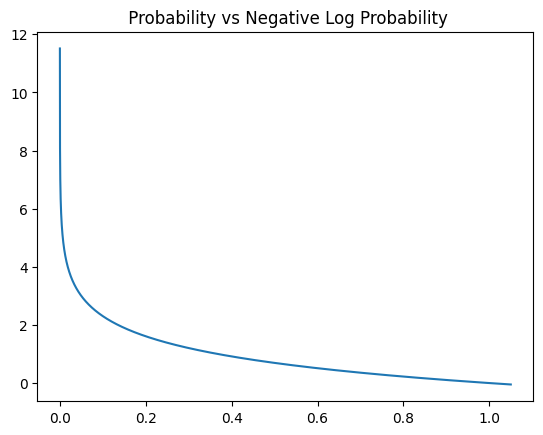

In [103]:
xs = np.arange(0, 1.05, 0.00001)
plt.plot(xs, -np.log(xs))
plt.title(" Probability vs Negative Log Probability")

In [ ]:
negative_log_likehood_trained_bigram = 0
negative_log_likehood_random_bigram = 0
for w in words[:3]:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = count_probs[idx1, idx2]
        negative_log_likehood_trained_bigram += torch.log(prob)

        prob = uniform_probability_distribution[idx1, idx2]
        negative_log_likehood_random_bigram += torch.log(prob)

negative_log_likehood_trained_bigram *= -1
negative_log_likehood_random_bigram *= -1

print(f"Negative Log Likehood (NLL) for our trained bigram model for the first three words: {words[:3]} is {negative_log_likehood_trained_bigram}")
print(f"Negative Log Likehood (NLL) for a random bigram model for the first three words: {words[:3]} is {negative_log_likehood_random_bigram}")

Negative Log Likehood (NLL) for our trained bigram model for the first three words: ['emma', 'olivia', 'ava'] is 38.78563690185547
Negative Log Likehood (NLL) for a random bigram model for the first three words: ['emma', 'olivia', 'ava'] is 52.733394622802734


Thus we can see that the NLL for our trained model is lower than a random model, which means it is a better model. Also, generally for an entire dataset (or a batch), we report the **normalised NLL** (also called the **average NLL** or **per-example loss**) where we divide the NLL by the number of samples.

Why normalise? Because raw NLL grows with dataset size — a dataset with 32K words will naturally have a higher total NLL than one with 100 words, even if the model is equally good on both. Dividing by the number of examples makes the metric comparable across datasets of different sizes and across different batch sizes during training.


In [78]:
negative_log_likehood_trained_bigram = 0
negative_log_likehood_random_bigram = 0
for w in words:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = count_probs[idx1, idx2]
        negative_log_likehood_trained_bigram += torch.log(prob)

        prob = uniform_probability_distribution[idx1, idx2]
        negative_log_likehood_random_bigram += torch.log(prob)

negative_log_likehood_trained_bigram /= -len(words)
negative_log_likehood_random_bigram /= -len(words)

print(f"Normalized Negative Log Likehood (NLL) for our trained bigram model for the entire dataset is {negative_log_likehood_trained_bigram}")
print(f"Normalized Negative Log Likehood (NLL) for a random bigram model for the entire dataset is {negative_log_likehood_random_bigram}")

Normalized Negative Log Likehood (NLL) for our trained bigram model for the entire dataset is 17.478591918945312
Normalized Negative Log Likehood (NLL) for a random bigram model for the entire dataset is 23.47516441345215


# Section 2.3: Model Smoothing

Our count-based bigram model has a critical flaw: any bigram that never appeared in the training data gets a probability of **exactly zero**. This means if we encounter such a bigram at evaluation time, the log likelihood becomes -∞ and the entire model "breaks." This is a well-known problem in n-gram language modelling, and the standard fix is **smoothing** — adding a small constant to all counts before normalising.

The technique we use here is called **Laplace smoothing** (also known as add-one smoothing or additive smoothing). The idea is simple: pretend we saw every possible bigram at least once, even if we didn't.


In [ ]:
# lets check the model quality on this particular word now

for w in ["andrej"]:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = count_probs[idx1, idx2]
        log_likehood += torch.log(prob)
        print(f"{c1}{c2}: NLL: {-log_likehood:.4f}")

.a: NLL: 104.1538
an: NLL: 105.9834
nd: NLL: 109.2428
dr: NLL: 111.8048
re: NLL: 113.8175
ej: NLL: 119.7346
j.: NLL: 123.4444


In [ ]:
# okay lets try another word now

for w in ["andrejq"]:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = count_probs[idx1, idx2]
        log_likehood += torch.log(prob)
        print(f"{c1}{c2}: NLL: {-log_likehood:.4f}")

.a: NLL: 125.4273
an: NLL: 127.2569
nd: NLL: 130.5162
dr: NLL: 133.0783
re: NLL: 135.0910
ej: NLL: 141.0081
jq: NLL: inf
q.: NLL: inf


We see `inf` NLL for `jq`. This is because in our probability distribution, the probability of a `q` occurring after the character `j` is zero — and log(0) = -∞, so -log(0) = ∞.

This is not ideal. A good model should be able to say "this is very unlikely" without saying "this is literally impossible." The way to fix this is **Laplace smoothing**: add a small constant (typically 1) to every cell in the count matrix _before_ calculating the probability distribution. This ensures every bigram has a non-zero probability, even if it's tiny.

**The smoothing factor is a hyperparameter.** A larger value pushes the model toward a uniform distribution (every bigram equally likely), while a smaller value keeps the model closer to the raw counts. A value of 1 (add-one smoothing) is the classic choice, but in practice you might use fractional values like 0.01 or 0.1 to stay closer to the empirical distribution.

This is also conceptually related to **regularisation** in neural networks — we're preventing the model from being too confident (assigning zero probability to anything), at the cost of slightly less accurate probabilities for common bigrams.


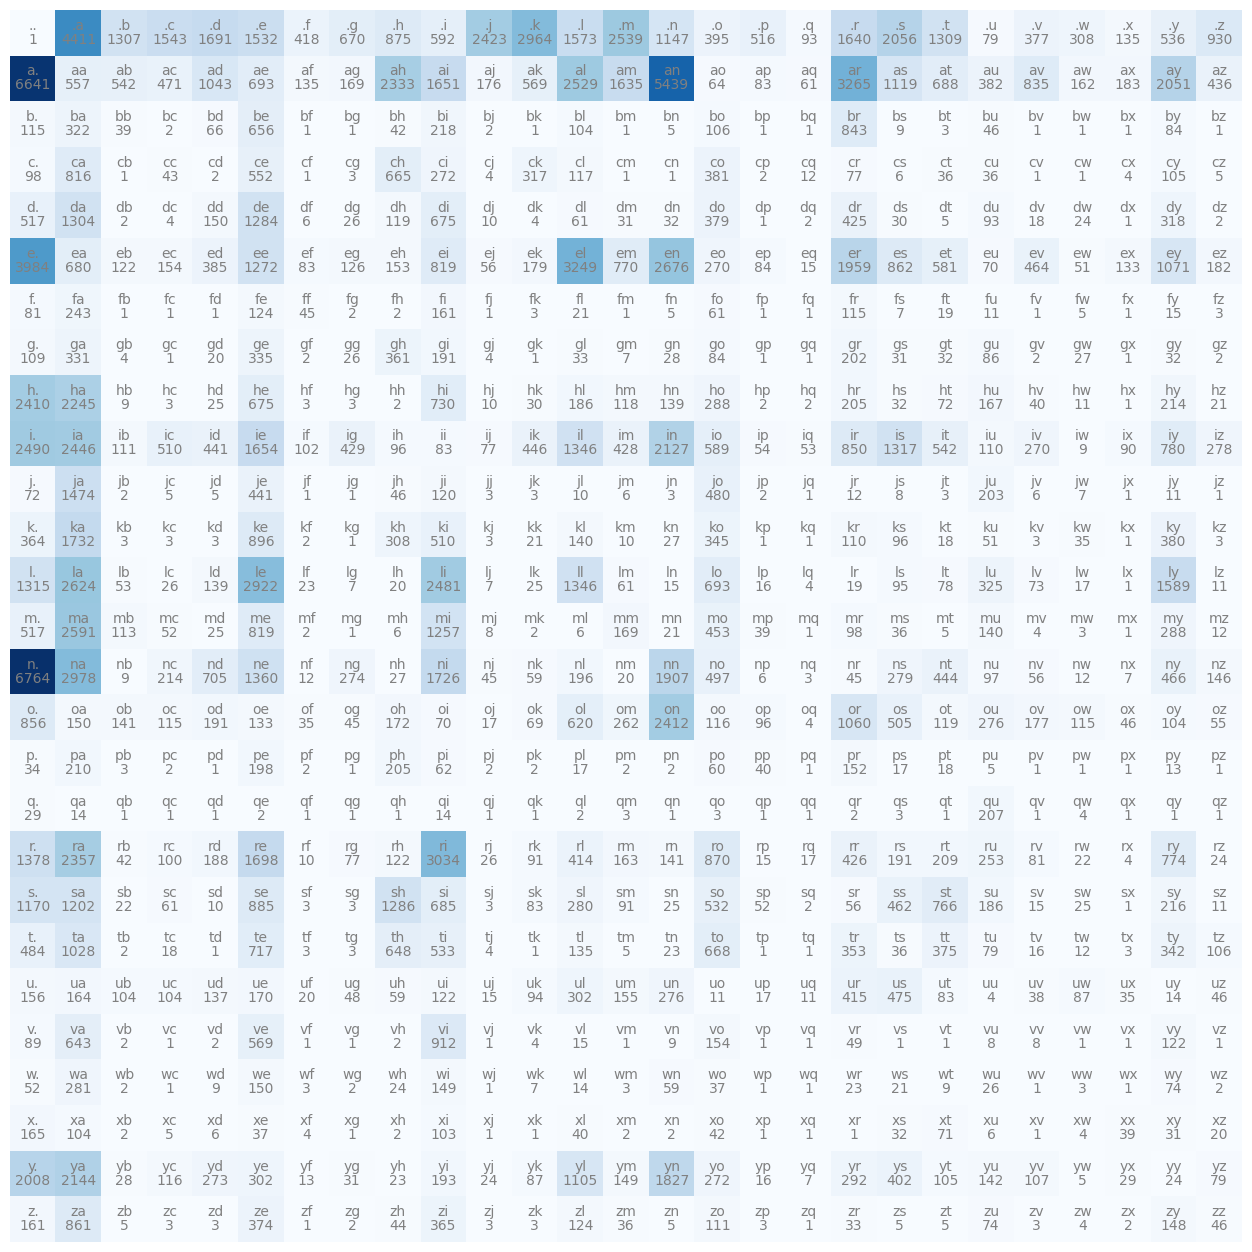

In [94]:
smoothed_count = counts + 1
pretty_plot_matrix(smoothed_count)

In [95]:
smoothed_count_probs = smoothed_count / smoothed_count.sum(axis=1, keepdim=True)
log_likehood = 0
for w in ["andrejq"]:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = smoothed_count_probs[idx1, idx2]
        log_likehood += torch.log(prob)
        print(f"{c1}{c2}: NLL: {-log_likehood:.4f}")

.a: NLL: 1.9835
an: NLL: 3.8137
nd: NLL: 7.0731
dr: NLL: 9.6377
re: NLL: 11.6519
ej: NLL: 17.5523
jq: NLL: 25.5341
q.: NLL: 27.8672


This worked now — it's saying `jq` has a NLL of ~25 which is much higher than that of `an` (~3.8). So it's saying that `jq` is much less likely (though not impossible like with the `inf` above) than `an`. The model can now handle any input sequence without breaking, while still correctly reflecting that `jq` is far more unusual than `an`.

Let's now see what happens when we crank up the smoothing factor to an extreme value to build intuition about this trade-off.


In [102]:
smoothed_count = counts + 1e30
smoothed_count_probs = smoothed_count / smoothed_count.sum(axis=1, keepdim=True)
log_likehood = 0
for w in ["andrejq"]:
    all_chars = SPECIAL_TOKEN + w + SPECIAL_TOKEN
    for c1, c2 in zip(all_chars, all_chars[1:]):
        idx1 = stoi[c1]
        idx2 = stoi[c2]

        # get the probability of this transition from c1 -> c2
        prob = smoothed_count_probs[idx1, idx2]
        log_likehood += torch.log(prob)
        print(f"{c1}{c2}: NLL: {-log_likehood:.4f}")

.a: NLL: 3.2958
an: NLL: 6.5917
nd: NLL: 9.8875
dr: NLL: 13.1833
re: NLL: 16.4792
ej: NLL: 19.7750
jq: NLL: 23.0709
q.: NLL: 26.3667


We can observe the effect of smoothing strength above. With +1 smoothing, the model preserved the distinction well: `an` had NLL of 3.8 while `jq` had NLL of 25.5 — a huge gap reflecting that `an` is vastly more common. With extreme smoothing (+1e30), the gap shrinks dramatically: `an` has NLL of 6.5 while `jq` has NLL of 23.0.

What's happening is that when the smoothing constant dwarfs the actual counts, every row of the probability matrix converges to a uniform 1/27 distribution — the model effectively "forgets" what it learned from the data. This is the **bias-variance trade-off** at play:

- **No smoothing (α=0):** The model trusts the data completely. Great for common bigrams, but assigns zero probability to anything unseen (infinite loss).
- **Mild smoothing (α=1):** The model slightly hedges its bets. Rare bigrams get a small non-zero probability. Common bigrams barely change.
- **Extreme smoothing (α→∞):** The model ignores the data entirely and falls back to uniform predictions. No bigram is special.

In practice, you'd choose the smoothing factor that gives the best loss on a held-out **validation set** — data the model didn't train on. This is the first hint of a pattern we'll see throughout the series: hyperparameter tuning via validation.
